# Cardiovascular Risk Analysis

## Import Libraries

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
import statsmodels.api as sm

## Data Loading and Cleaning

In [87]:
df = pd.read_csv('/Users/alex/Downloads/Cardiovascularstudy/train.csv')
df.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,64,2.0,F,YES,3.0,0.0,0,0,0,221.0,148.0,85.0,NaN,90.0,80.0,1
1,1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


'Id' column has been removed, since it is not relevant for analysis.

In [88]:
df = df.drop('id', axis=1)

#### Checking the type of data 

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              3390 non-null   int64  
 1   education        3303 non-null   float64
 2   sex              3390 non-null   object 
 3   is_smoking       3390 non-null   object 
 4   cigsPerDay       3368 non-null   float64
 5   BPMeds           3346 non-null   float64
 6   prevalentStroke  3390 non-null   int64  
 7   prevalentHyp     3390 non-null   int64  
 8   diabetes         3390 non-null   int64  
 9   totChol          3352 non-null   float64
 10  sysBP            3390 non-null   float64
 11  diaBP            3390 non-null   float64
 12  BMI              3376 non-null   float64
 13  heartRate        3389 non-null   float64
 14  glucose          3086 non-null   float64
 15  TenYearCHD       3390 non-null   int64  
dtypes: float64(9), int64(5), object(2)
memory usage: 423.9+ KB


In [90]:
df.nunique()

age                  39
education             4
sex                   2
is_smoking            2
cigsPerDay           32
BPMeds                2
prevalentStroke       2
prevalentHyp          2
diabetes              2
totChol             240
sysBP               226
diaBP               142
BMI                1259
heartRate            68
glucose             132
TenYearCHD            2
dtype: int64

Categorical binary columns: 'sex', 'is_smoking', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD'

Categorical ordinary columns: 'education'

Continuous variables: 'age', 'cigsPerDay', 'totChol' , 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose'

### Treating outliers in continious variables

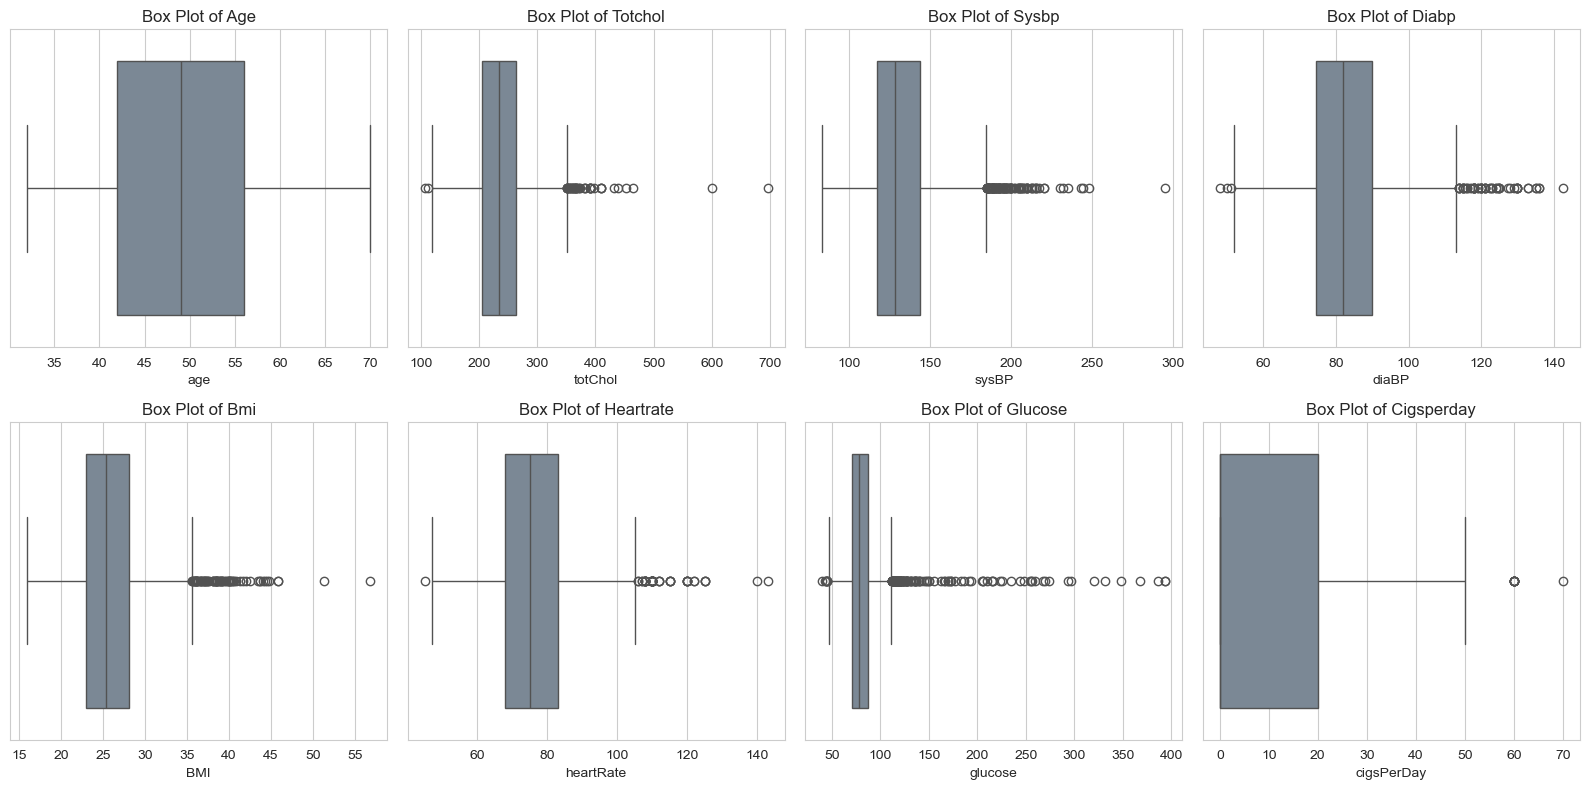

In [91]:
variables = ['age', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'cigsPerDay']
plt.figure(figsize=(16, 8))
for i, var in enumerate(variables, 1):  
    plt.subplot(2, 4, i)  
    sns.boxplot(x=df[var], color='lightslategrey')
    plt.title(f'Box Plot of {var.capitalize()}', fontsize=12)
    plt.xlabel(var, fontsize=10)
plt.tight_layout()
plt.show()

The results of outliers' analysis suggest that there are significant outliers in total cholesterol level, both systolic and diastolic blood pressure, body mass index, heart rate, glucose level. Some outliers in cigarettes per day and no outliers in the age column.

In [92]:
def count_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return len(outliers)

columns_to_handle_outliers = ['cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose']
print("Number of outliers before handling:")
outliers_before = {col: count_outliers(df, col) for col in columns_to_handle_outliers}
for col, count in outliers_before.items():
    print(f"{col}: {count} outliers")

Number of outliers before handling:
cigsPerDay: 9 outliers
totChol: 43 outliers
sysBP: 105 outliers
diaBP: 58 outliers
BMI: 77 outliers
heartRate: 64 outliers
glucose: 158 outliers


Outliers has been treated by the replacement of values.  Values below the lower quantile are replaced with the lower limit, and values above the upper quantile are capped at the upper limit.

In [93]:
def handle_outliers(df, col, lower_quantile=0.05, upper_quantile=0.95):
    lower_limit = df[col].quantile(lower_quantile)
    upper_limit = df[col].quantile(upper_quantile)
    df[col] = df[col].apply(lambda x: lower_limit if x < lower_limit else upper_limit if x > upper_limit else x)
for col in columns_to_handle_outliers:
    handle_outliers(df, col)

Double-check the continuous variables for outliers. Most of the charts show no outliers after cleaning.

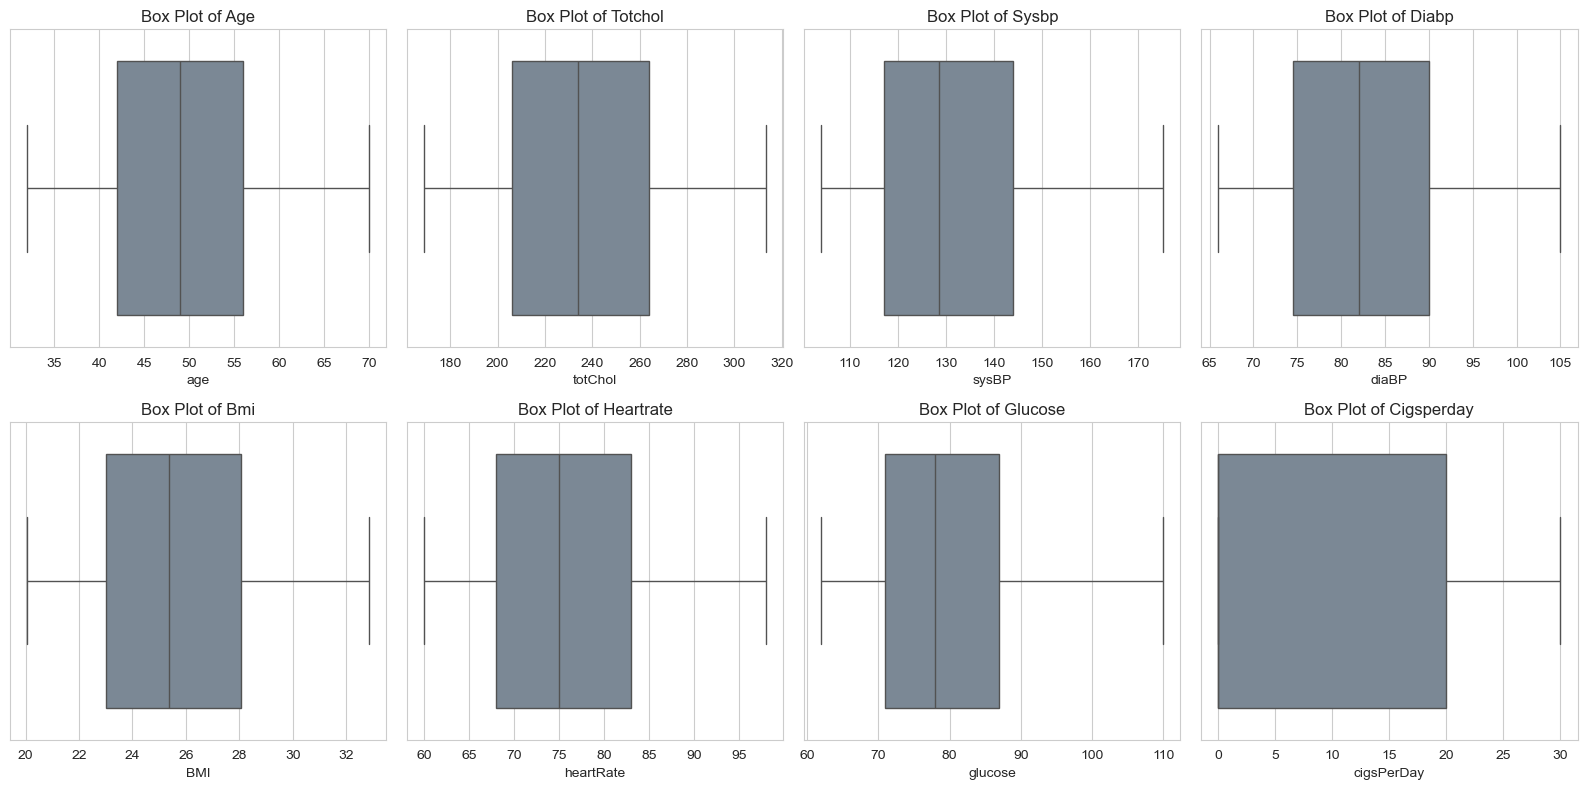

In [94]:
plt.figure(figsize=(16, 8))
for i, var in enumerate(variables, 1):
    plt.subplot(2, 4, i)
    sns.boxplot(x=df[var], color='lightslategrey')
    plt.title(f'Box Plot of {var.capitalize()}', fontsize=12)
    plt.xlabel(var, fontsize=10)
plt.tight_layout()
plt.show()

### Handling Missing Values

In [95]:
df.isnull().sum()

age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

Glucose column has the highest number of missing values.  For filling them median values have been used.

In [96]:
glucose_median = df['glucose'].median()
df['glucose'] = df['glucose'].fillna(glucose_median)

K-nearest neighbor method is used for replacement missing values in categorical variable such as education

In [97]:
print("Value counts before imputation:")
print(df['education'].value_counts(dropna=False))  

Value counts before imputation:
education
1.0    1391
2.0     990
3.0     549
4.0     373
NaN      87
Name: count, dtype: int64


In [98]:
imputer = KNNImputer(n_neighbors=5)
df[['education']] = imputer.fit_transform(df[['education']])
df['education'] = df['education'].round()
print("\nValue counts after imputation:")
print(df['education'].value_counts())


Value counts after imputation:
education
1.0    1391
2.0    1077
3.0     549
4.0     373
Name: count, dtype: int64


All the misiing values in 'education' have been replaced to 2.0

Since the number of rows with missing values in the other five columns is below 5%, they have been dropped (3.5% of total).

In [99]:
original_row_count = len(df)
columns_to_check = ['cigsPerDay', 'BPMeds', 'totChol', 'BMI', 'heartRate']
df = df.dropna(subset=columns_to_check)
new_row_count = len(df)
dropped_rows = original_row_count - new_row_count
percentage_dropped = (dropped_rows / original_row_count) * 100
print(f'Total rows dropped: {dropped_rows}')
print(f'Percentage of rows dropped: {percentage_dropped:.2f}%')

Total rows dropped: 118
Percentage of rows dropped: 3.48%


In [100]:
df.isnull().sum()

age                0
education          0
sex                0
is_smoking         0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

There are no missing values now and data is ready for further processing.

In [101]:
df.shape

(3272, 16)

Sample size is 3272 rows and there are 16 variables

Encoding certain variables such as the 'sex' and 'is_smoking' columns to binary. Male is 1 and female is 0, Smoking is 1 and non-smoking is 0.

In [102]:
df['sex_encoded'] = df['sex'].map({'M': 1, 'F': 0})
df['is_smoking_encoded'] = df['is_smoking'].map({'YES': 1, 'NO': 0})
df.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,sex_encoded,is_smoking_encoded
1,36,4.0,M,NO,0.0,0.0,0,1,0,212.0,168.000,98.0,29.77,72.0,75.0,0,1,0
2,46,1.0,F,YES,10.0,0.0,0,0,0,250.0,116.000,71.0,20.35,88.0,94.0,0,0,1
3,50,1.0,M,YES,20.0,0.0,0,1,0,233.0,158.000,88.0,28.26,68.0,94.0,1,1,1
4,64,1.0,F,YES,30.0,0.0,0,0,0,241.0,136.500,85.0,26.42,70.0,77.0,0,0,1
5,61,3.0,F,NO,0.0,0.0,0,1,0,272.0,175.275,105.0,32.80,85.0,65.0,1,0,0


In [103]:
df[df.duplicated()]

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,sex_encoded,is_smoking_encoded


There are no duplicated rows in the dataframe.

#### Descriptive statistics

In [104]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,3272.0,49.442237,8.559199,32.00,42.00,49.00,56.000,70.0000
education,3272.0,1.973411,1.005440,1.00,1.00,2.00,3.000,4.0000
cigsPerDay,3272.0,8.557152,10.593880,0.00,0.00,0.00,20.000,30.0000
BPMeds,3272.0,0.029645,0.169633,0.00,0.00,0.00,0.000,1.0000
prevalentStroke,3272.0,0.005807,0.075993,0.00,0.00,0.00,0.000,1.0000
prevalentHyp,3272.0,0.313264,0.463892,0.00,0.00,0.00,1.000,1.0000
diabetes,3272.0,0.025672,0.158180,0.00,0.00,0.00,0.000,1.0000
totChol,3272.0,236.051482,39.704392,169.00,206.00,234.00,264.000,313.4500
sysBP,3272.0,131.819292,19.425362,104.00,117.00,128.00,143.625,175.2750
diaBP,3272.0,82.701253,10.542046,66.00,74.50,82.00,90.000,105.0000


The data seems reliable. 

#### Distribution of continious variables

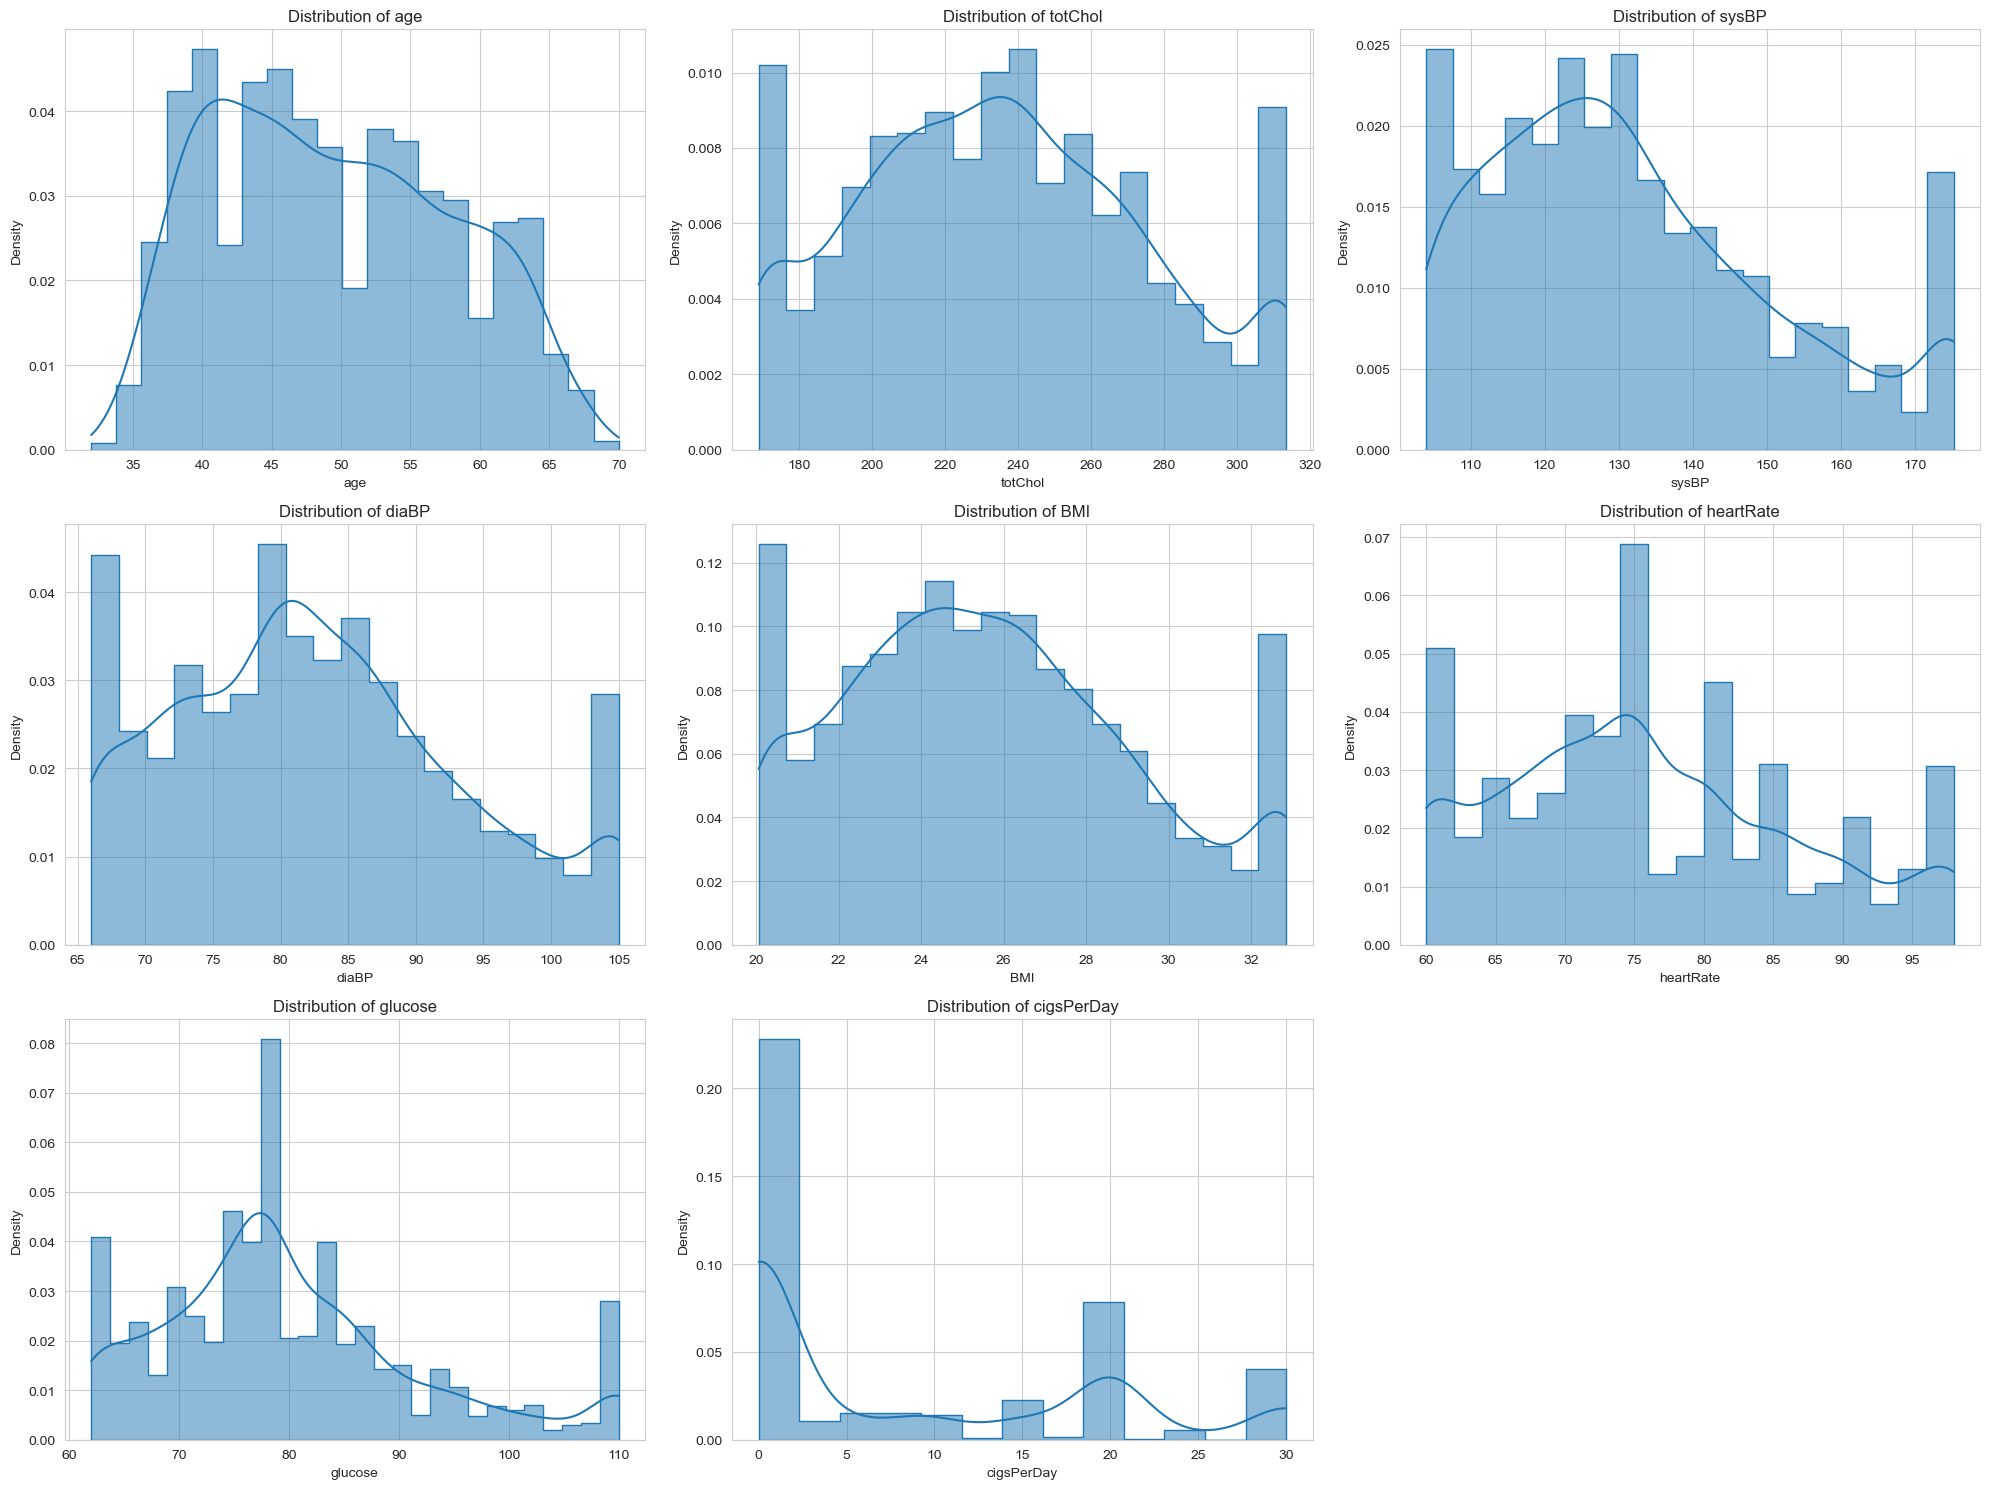

In [105]:
numerical_columns = ['age', 'totChol', 'sysBP', 'diaBP', 'BMI', 'heartRate', 'glucose', 'cigsPerDay']
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data=df, x=col, element='step', stat='density', common_norm=False, kde=True)
    plt.title(f'Distribution of {col}', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Density', fontsize=10)
plt.tight_layout()
plt.show()

Most of the variables exhibit significant right skewness. To address this, a logarithmic transformation will be applied prior to regression modeling. This transformation helps normalize the distributions  and improve overall model performance.

## Exploratory Data Analysis

#### Distribution in binary columns of TenYearCHD

In [106]:
binary_columns = ['sex_encoded', 'is_smoking_encoded', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes']
binary_distribution = {}
for col in binary_columns:
    distribution = df.groupby(col)['TenYearCHD'].value_counts(normalize=True).unstack() * 100
    binary_distribution[col] = distribution

binary_table = pd.concat(binary_distribution, axis=1)
binary_table_transposed = binary_table.T
binary_table_transposed.columns = ['No', 'Yes']
print("Percentage Distribution for Categorical Binary Columns (No Disease(0) and Disease(1)):")
binary_table_transposed

Percentage Distribution for Categorical Binary Columns (No Disease(0) and Disease(1)):


No        Yes
                   TenYearCHD                      
sex_encoded        0           87.860642  81.533101
                   1           12.139358  18.466899
is_smoking_encoded 0           86.489747  83.643123
                   1           13.510253  16.356877
BPMeds             0           85.637795  67.010309
                   1           14.362205  32.989691
prevalentStroke    0           85.213649  63.157895
                   1           14.786351  36.842105
prevalentHyp       0           88.963062  76.585366
                   1           11.036938  23.414634
diabetes           0           85.633626  64.285714
                   1           14.366374  35.714286

- There are more diseased smokers (16.4%) than non-smokers (13.5%).  
- People with blood pressure medication have prevalence of CHD(33%), which could suggest either a higher risk or more severe cases requiring medication .  
- Patients with stroke in the past are more likely to have CHD (36.8%).  
- Hypertensive patients (23.4%) have a higher rate of CHD compared to those without hypertension.  
- Diabetes is associated with a higher likelihood of CHD (35.7%) comparing to those who had not.  

In [107]:
ordinal_column = 'education'
education_distribution = pd.crosstab(df[ordinal_column], df['TenYearCHD'], normalize='index') * 100
print(f"\nDistribution of {ordinal_column} by TenYearCHD:\n")
print(education_distribution)


Distribution of education by TenYearCHD:

TenYearCHD          0          1
education                       
1.0         81.838565  18.161435
2.0         87.823586  12.176414
3.0         87.193974  12.806026
4.0         86.111111  13.888889


In every binary categorical columns the percentage of people with the disease is higher when the factor is recorded. For ordinary column 'education', people with lower education level have the most diseased cases. 

##### Categorical variables proportions

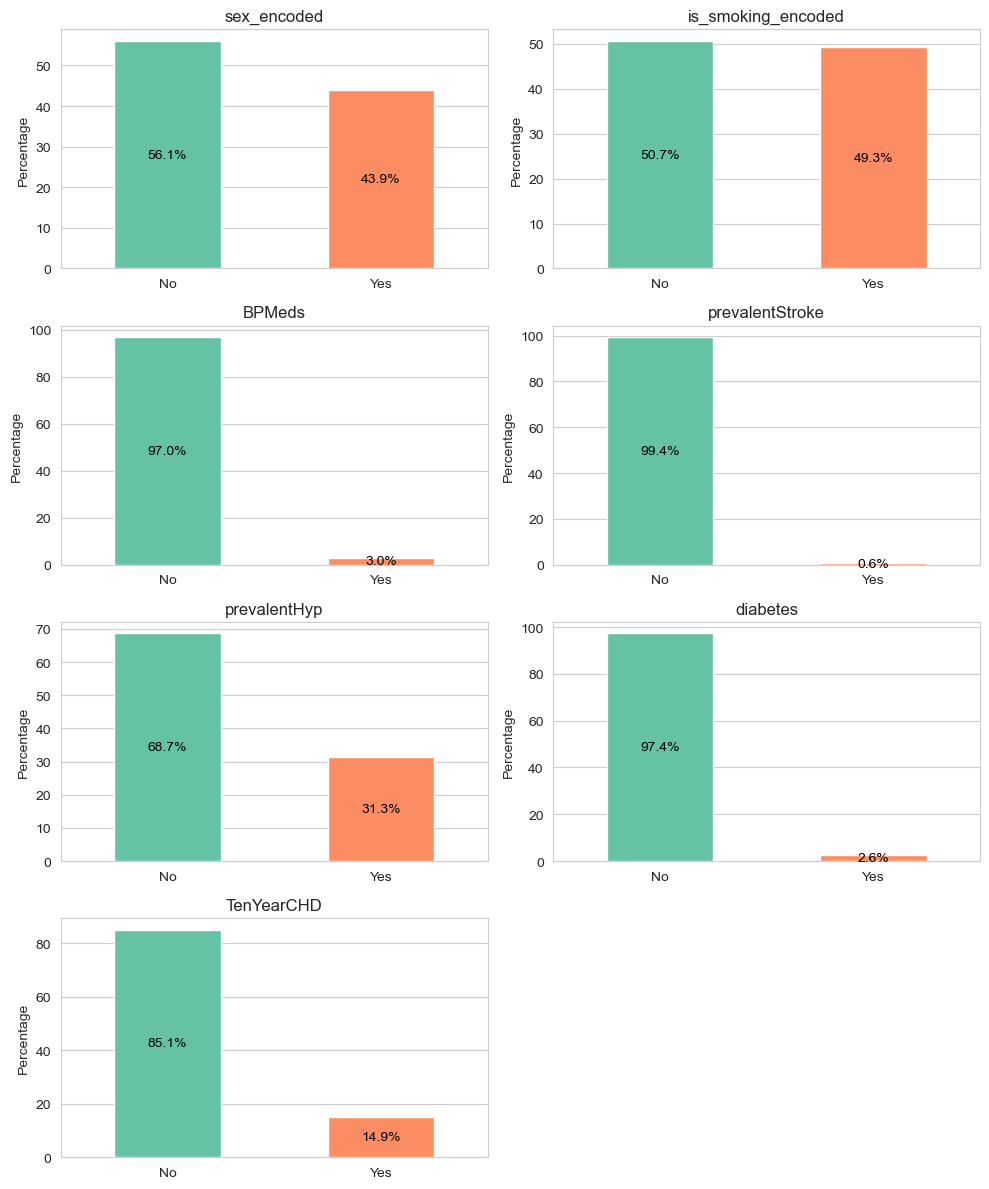

In [108]:
bin_columns = [
    'sex_encoded', 'is_smoking_encoded', 'BPMeds', 
    'prevalentStroke', 'prevalentHyp', 'diabetes', 'TenYearCHD'
]
cat_var_proportions = df[bin_columns].apply(
    lambda x: (x.value_counts(normalize=True) * 100).round(1)
).T
sorted_by_third_col = cat_var_proportions.sort_values(
    by=cat_var_proportions.columns[1], ascending=True
)

plt.rcParams['figure.figsize'] = (10, 8)
fig, axes = plt.subplots(nrows=(len(bin_columns) + 1) // 2, ncols=2, figsize=(10, 12))
axes = axes.flatten()

for i, col in enumerate(bin_columns):
    sorted_by_third_col.loc[col].plot(kind='bar', ax=axes[i], color=['#66c2a5', '#fc8d62'], title=col)
    
    axes[i].set_xticklabels(['No', 'Yes'])
    
    for p in axes[i].patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        if height > 0:
            axes[i].text(x + width / 2, y + height / 2, f'{height:.1f}%', ha='center', va='center', fontsize=10, color='black')
    
    axes[i].set_ylabel('Percentage')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].grid(False, axis='x')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The dataset has severe class imbalance problem with 'prevalentStroke' , 'diabetes', 'BPMeds' variables. 

##### Number of individuals that have or do not have TenYearCHD

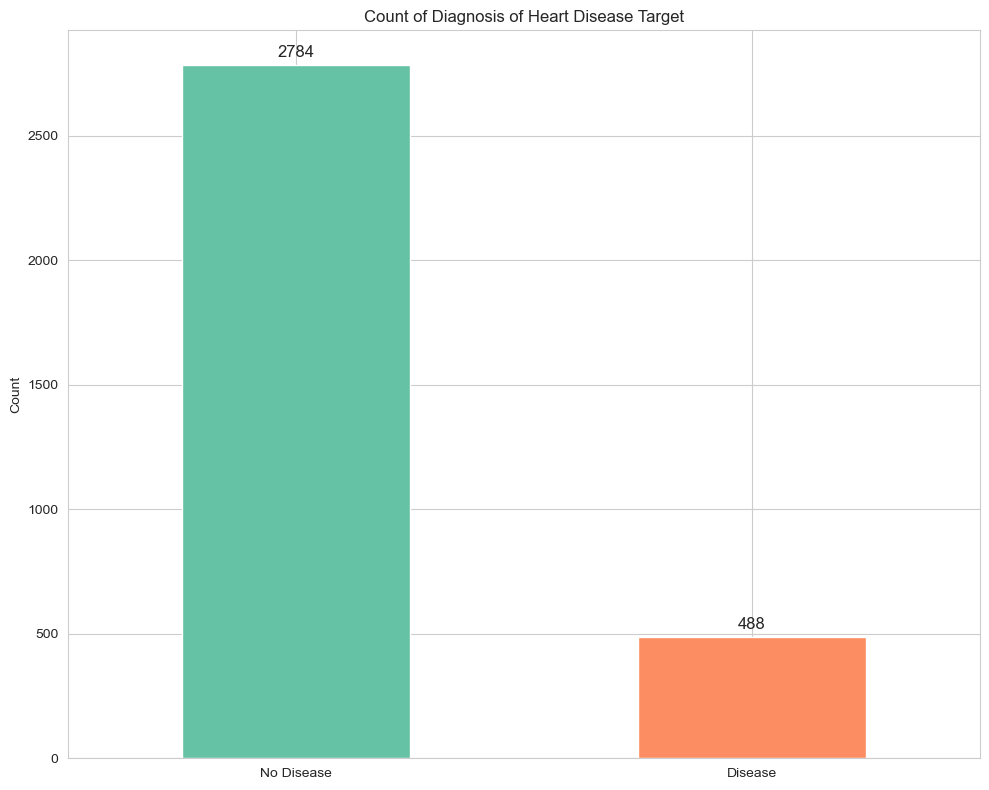

In [109]:
chd_counts = df['TenYearCHD'].value_counts()
chd_counts.index = ['No Disease', 'Disease']
ax = chd_counts.plot(kind='bar', color=['#66c2a5', '#fc8d62'], title="Count of Diagnosis of Heart Disease Target")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 50, f'{height:.0f}', ha='center', va='center', fontsize=12)
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

The target variable 'TenYearCHD' is also imbalanced. There are 14.9% of people with the disease, comparing to 85.1% of healthy people.

####  People with TenYearCHD by Age Group

/var/folders/ft/2bl2stsj05b84gz2r09gn9h40000gn/T/ipykernel_5682/1561610462.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = df.groupby(['age_group', 'TenYearCHD']).size().unstack()


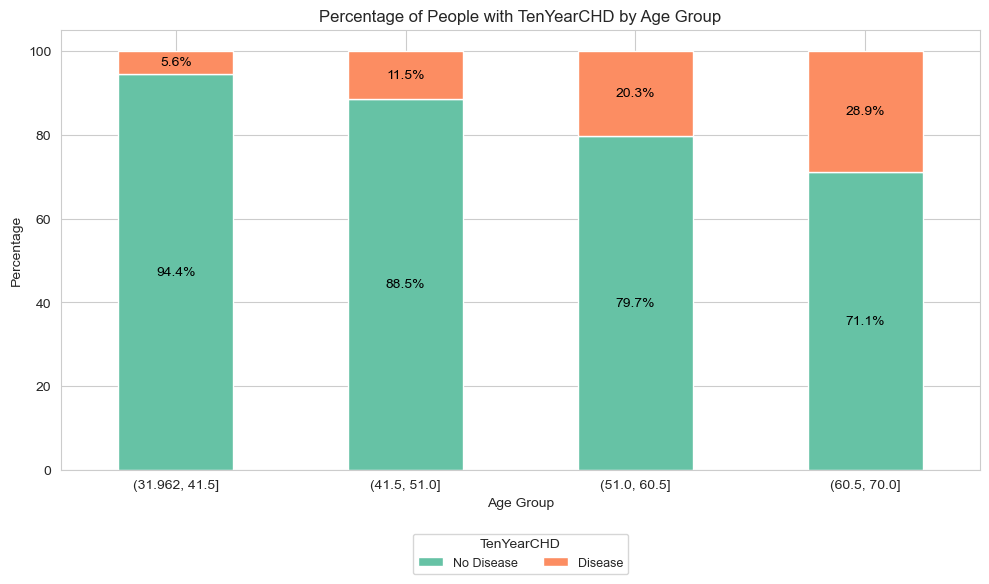

In [110]:
bins = 4  
df['age_group'] = pd.cut(df['age'], bins=bins)
count_df = df.groupby(['age_group', 'TenYearCHD']).size().unstack()
percentage_df = count_df.div(count_df.sum(axis=1), axis=0) * 100
percentage_df.columns = ['No Disease', 'Disease']
plt.rcParams['figure.figsize'] = (10, 6)
ax = percentage_df.plot(kind='bar', stacked=True, color=['#66c2a5', '#fc8d62'])
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:  
        ax.text(x + width/2, y + height/2, f'{height:.1f}%', ha='center', va='center', fontsize=10, color='black')
plt.xticks(rotation=0)  
plt.title('Percentage of People with TenYearCHD by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage')
plt.legend(title='TenYearCHD', fontsize=9, title_fontsize=10, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.tight_layout()
plt.show()

The likelihood of disease increases with age. In the 60.5-70 year age group, 28.9% of people are affected, compared to just over 20% in the 51-60.5 year group.

#### People with TenYearCHD by Sex

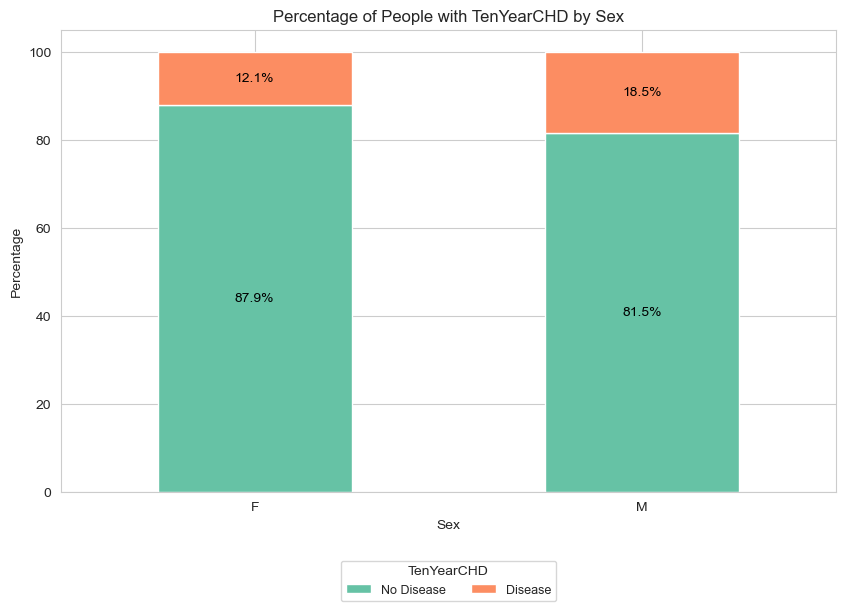

In [111]:
count_df = df.groupby(['sex', 'TenYearCHD']).size().unstack()
percentage_df = count_df.div(count_df.sum(axis=1), axis=0) * 100
percentage_df.columns = ['No Disease', 'Disease']
plt.rcParams['figure.figsize'] = (10, 6)
ax = percentage_df.plot(kind='bar', stacked=True, color=['#66c2a5', '#fc8d62'])
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy() 
    if height > 0:  
        ax.text(x + width/2, y + height/2, f'{height:.1f}%', ha='center', va='center', fontsize=10, color='black')

plt.xticks(rotation=0)
plt.title('Percentage of People with TenYearCHD by Sex')
plt.xlabel('Sex')
plt.ylabel('Percentage')
plt.legend(title='TenYearCHD', fontsize=9, title_fontsize=10, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.show()

In the population by sex, more males (18.5%) are diseased compared to females (12.1%). This indicates that men are more likely to be affected by the disease.

#### Impact of smoking

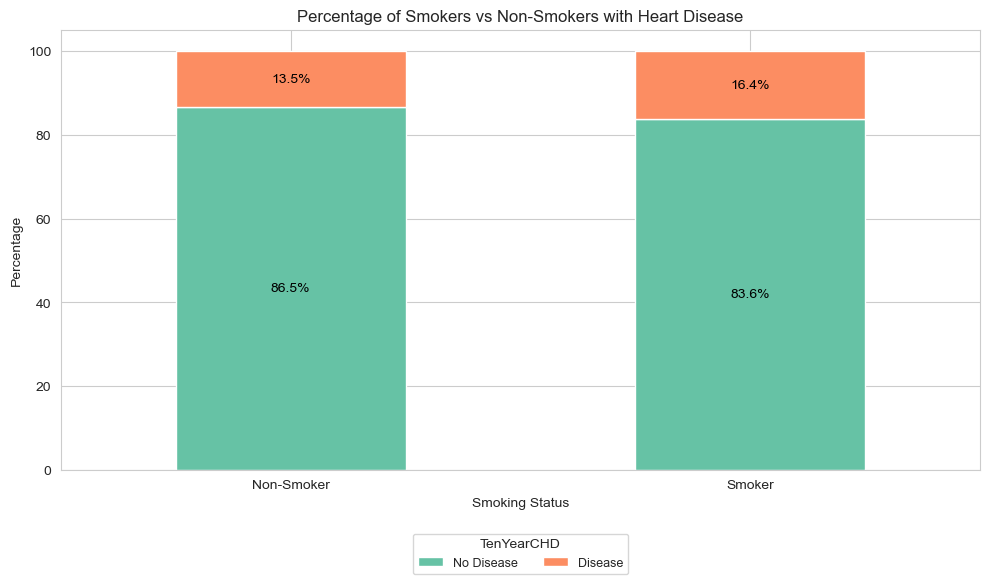

In [112]:
smoking_chd_counts = df.groupby(['is_smoking_encoded', 'TenYearCHD']).size().unstack()
smoking_chd_counts.index = ['Non-Smoker', 'Smoker']
percentage_df = smoking_chd_counts.div(smoking_chd_counts.sum(axis=1), axis=0) * 100
percentage_df.columns = ['No Disease', 'Disease']
plt.rcParams['figure.figsize'] = (10, 6)
ax = percentage_df.plot(kind='bar', stacked=True, color=['#66c2a5', '#fc8d62'])
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x + width/2, y + height/2, f'{height:.1f}%', ha='center', va='center', fontsize=10, color='black')
        
plt.xticks(rotation=0)
plt.title('Percentage of Smokers vs Non-Smokers with Heart Disease')
plt.xlabel('Smoking Status')
plt.ylabel('Percentage')
plt.legend(title='TenYearCHD', fontsize=9, title_fontsize=10, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.tight_layout()
plt.show()

Current evidence suggests that smoking does not significantly increase the likelihood of heart disease, as the percentage of smokers with the disease is only 3% higher than that of non-smokers. Further investigation through correlation analysis will provide more detailed insights by revealing the R coefficient and the nature of the relationship between smoking and heart disease.

/var/folders/ft/2bl2stsj05b84gz2r09gn9h40000gn/T/ipykernel_5682/2627764877.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = df.groupby(['cigsPerDay_group', 'TenYearCHD']).size().unstack()


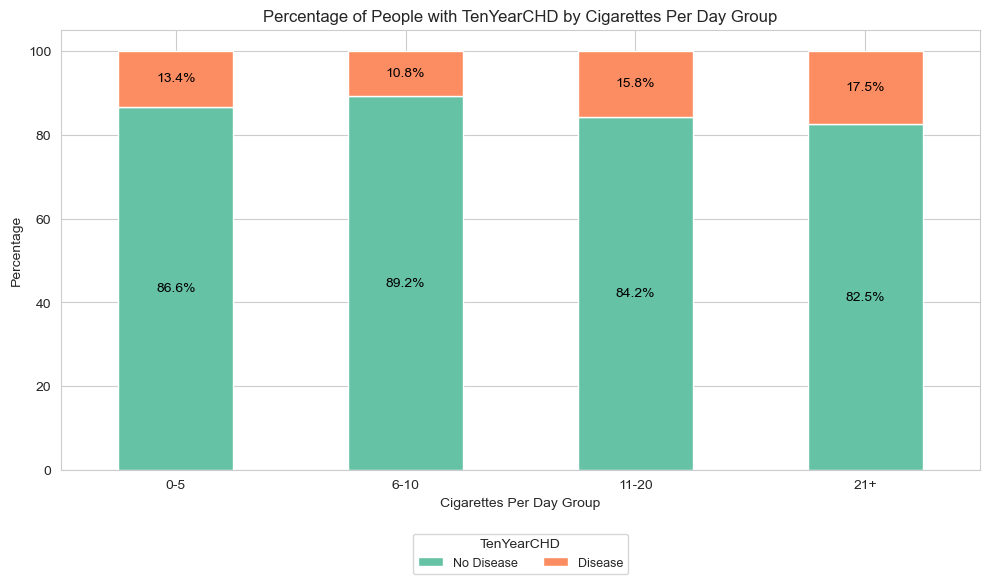

In [113]:
bins = [0, 5, 10, 20, df['cigsPerDay'].max()]
labels = ['0-5', '6-10', '11-20', '21+']
df['cigsPerDay_group'] = pd.cut(df['cigsPerDay'], bins=bins, labels=labels, right=False)
count_df = df.groupby(['cigsPerDay_group', 'TenYearCHD']).size().unstack()
percentage_df = count_df.div(count_df.sum(axis=1), axis=0) * 100
percentage_df.columns = ['No Disease', 'Disease']
plt.rcParams['figure.figsize'] = (10, 6)
ax = percentage_df.plot(kind='bar', stacked=True, color=['#66c2a5', '#fc8d62'])
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x + width / 2, y + height / 2, f'{height:.1f}%', ha='center', va='center', fontsize=10, color='black')
plt.xticks(rotation=0)
plt.title('Percentage of People with TenYearCHD by Cigarettes Per Day Group')
plt.xlabel('Cigarettes Per Day Group')
plt.ylabel('Percentage')
plt.legend(title='TenYearCHD', fontsize=9, title_fontsize=10, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.tight_layout()
plt.show()

It is interesting to note that individuals who smoke 5 or fewer cigarettes per day have a higher prevalence of heart disease compared to those who smoke between 6 and 10 cigarettes per day. In addition, as expected, the most smoking people have the highest number of diseased individuals.

#### Impact of Total Cholesterol

/var/folders/ft/2bl2stsj05b84gz2r09gn9h40000gn/T/ipykernel_5682/3835007898.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = df.groupby(['totChol_group', 'TenYearCHD']).size().unstack()


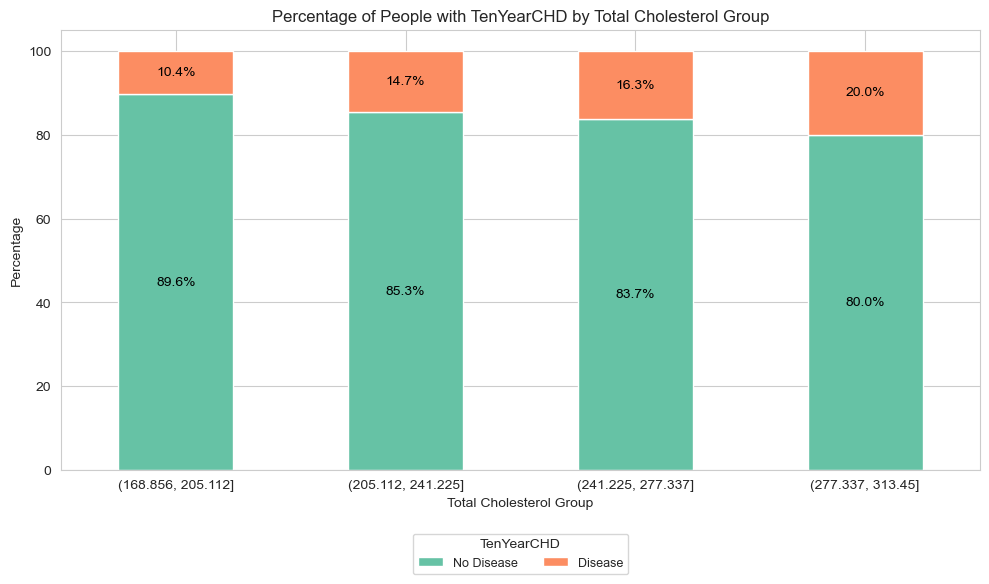

In [114]:
bins = 4
df['totChol_group'] = pd.cut(df['totChol'], bins=bins)
count_df = df.groupby(['totChol_group', 'TenYearCHD']).size().unstack()
percentage_df = count_df.div(count_df.sum(axis=1), axis=0) * 100
percentage_df.columns = ['No Disease', 'Disease']

plt.rcParams['figure.figsize'] = (10, 6)
ax = percentage_df.plot(kind='bar', stacked=True, color=['#66c2a5', '#fc8d62'])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x + width / 2, y + height / 2, f'{height:.1f}%', ha='center', va='center', fontsize=10, color='black')

plt.xticks(rotation=0)
plt.title('Percentage of People with TenYearCHD by Total Cholesterol Group')
plt.xlabel('Total Cholesterol Group')
plt.ylabel('Percentage')
plt.legend(title='TenYearCHD', fontsize=9, title_fontsize=10, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.tight_layout()
plt.show()

The percentage of individuals with heart disease increases with higher cholesterol levels. Approximately 20% of those with the highest cholesterol levels are diseased, compared to 10.4% in the group with the lowest cholesterol levels

#### Body Mass Index and CHD

/var/folders/ft/2bl2stsj05b84gz2r09gn9h40000gn/T/ipykernel_5682/2478929637.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = df.groupby(['BMI_group', 'TenYearCHD']).size().unstack()


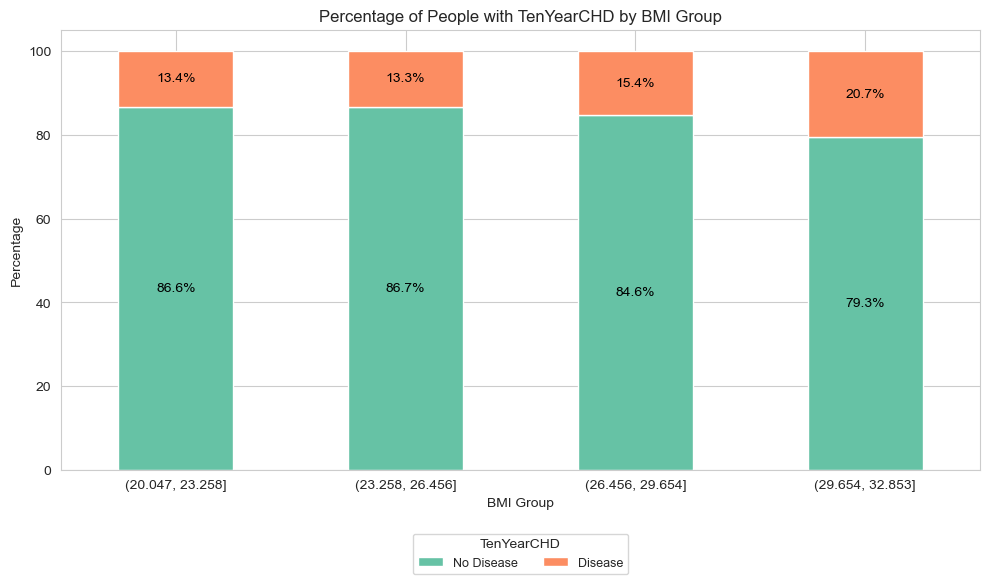

In [115]:

bins = 4
df['BMI_group'] = pd.cut(df['BMI'], bins=bins)
count_df = df.groupby(['BMI_group', 'TenYearCHD']).size().unstack()
percentage_df = count_df.div(count_df.sum(axis=1), axis=0) * 100
percentage_df.columns = ['No Disease', 'Disease']
plt.rcParams['figure.figsize'] = (10, 6)
ax = percentage_df.plot(kind='bar', stacked=True, color=['#66c2a5', '#fc8d62'])

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x + width / 2, y + height / 2, f'{height:.1f}%', ha='center', va='center', fontsize=10, color='black')

plt.xticks(rotation=0)
plt.title('Percentage of People with TenYearCHD by BMI Group')
plt.xlabel('BMI Group')
plt.ylabel('Percentage')
plt.legend(title='TenYearCHD', fontsize=9, title_fontsize=10, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.tight_layout()
plt.show()


Individuals with a higher body mass index (BMI) show a greater prevalence of heart disease. Approximately 20.7% of those with the highest BMI (greater than 29.65) are diseased. In contrast, individuals with low and below-average BMI have similar disease rates, with around 13% of individuals in these groups being diseased

#### Disease by Heart Rate Groups

/var/folders/ft/2bl2stsj05b84gz2r09gn9h40000gn/T/ipykernel_5682/4183763764.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  count_df = df.groupby(['heartRate_group', 'TenYearCHD']).size().unstack()


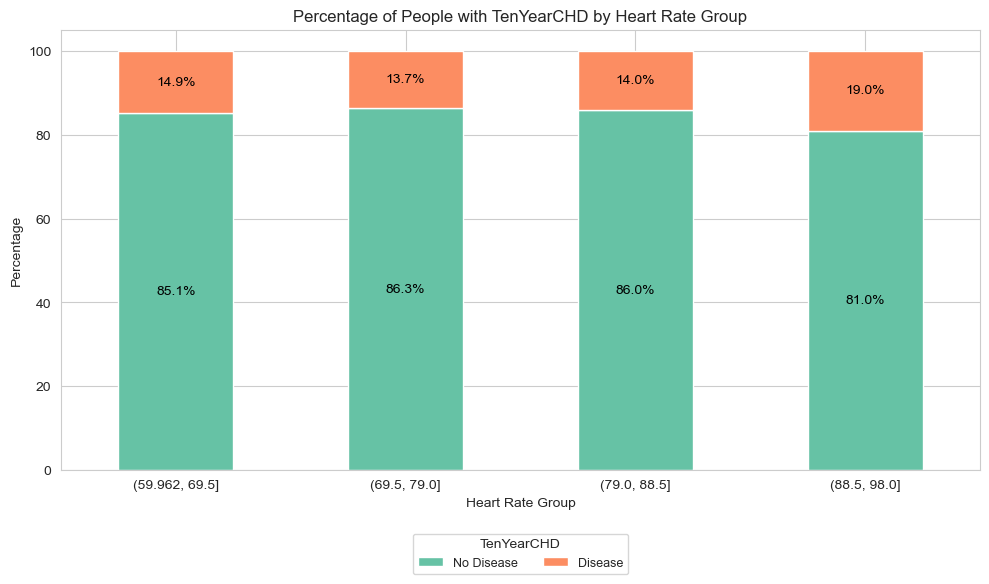

In [116]:
bins = 4
df['heartRate_group'] = pd.cut(df['heartRate'], bins=bins)
count_df = df.groupby(['heartRate_group', 'TenYearCHD']).size().unstack()
percentage_df = count_df.div(count_df.sum(axis=1), axis=0) * 100
percentage_df.columns = ['No Disease', 'Disease']
plt.rcParams['figure.figsize'] = (10, 6)
ax = percentage_df.plot(kind='bar', stacked=True, color=['#66c2a5', '#fc8d62'])
for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    if height > 0:
        ax.text(x + width / 2, y + height / 2, f'{height:.1f}%', ha='center', va='center', fontsize=10, color='black')
        
plt.xticks(rotation=0)
plt.title('Percentage of People with TenYearCHD by Heart Rate Group')
plt.xlabel('Heart Rate Group')
plt.ylabel('Percentage')
plt.legend(title='TenYearCHD', fontsize=9, title_fontsize=10, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=2)
plt.tight_layout()
plt.show()

Individuals with the highest heart rates show a slightly higher prevalence of heart disease, with 19% being diseased. However, a lower heart rate does not necessarily indicate a reduced risk of coronary heart disease (CHD).

#### Relationship between Age and Blood Pressure

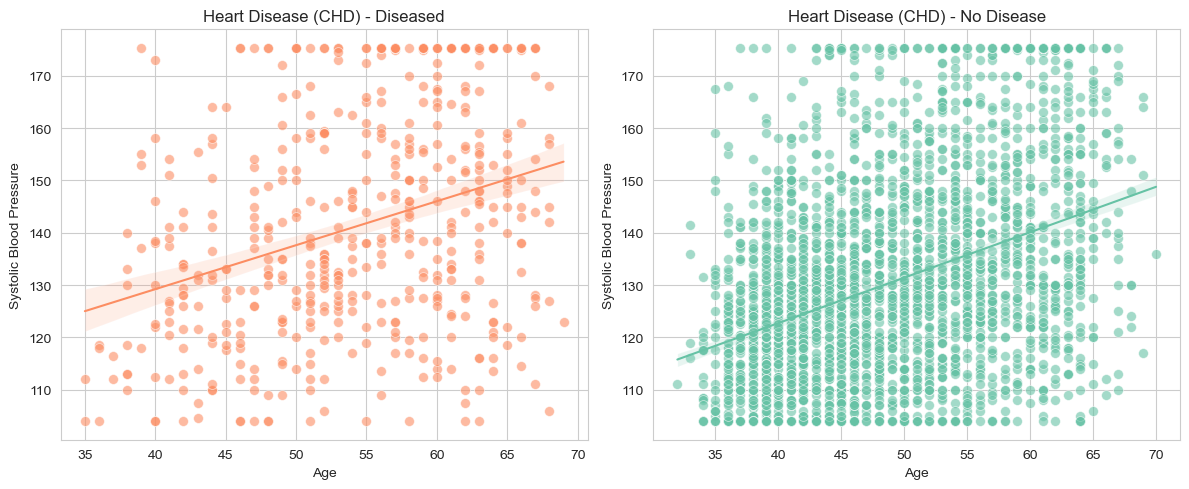

In [117]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=df[df['TenYearCHD'] == 1]['age'], 
                y=df.sysBP[df.TenYearCHD == 1], 
                color='#fc8d62', s=50, alpha=0.6)
sns.regplot(x=df[df['TenYearCHD'] == 1]['age'], 
            y=df.sysBP[df.TenYearCHD == 1], 
            scatter=False, color='#fc8d62', line_kws={'linewidth': 1.5})
plt.title("Heart Disease (CHD) - Diseased")
plt.xlabel("Age")
plt.ylabel("Systolic Blood Pressure")

plt.subplot(1, 2, 2)
sns.scatterplot(x=df[df['TenYearCHD'] == 0]['age'], 
                y=df.sysBP[df.TenYearCHD == 0], 
                color='#66c2a5', s=50, alpha=0.6)
sns.regplot(x=df[df['TenYearCHD'] == 0]['age'], 
            y=df.sysBP[df.TenYearCHD == 0], 
            scatter=False, color='#66c2a5', line_kws={'linewidth': 1.5})

plt.title("Heart Disease (CHD) - No Disease")
plt.xlabel("Age")
plt.ylabel("Systolic Blood Pressure")
plt.tight_layout()
plt.show()

Both healthy and diseased individuals generally exhibit lower systolic blood pressure at younger ages, with systolic pressure tending to rise as age increases. Moreover, there are more cases of heart disease among individuals with higher blood pressure. Additionally, elevated systolic pressure is observed in both groups, suggesting that while high blood pressure is more common in older individuals, it is not exclusively linked to heart disease.

#### Distribution of Glucose Levels by Diabetes Status

/var/folders/ft/2bl2stsj05b84gz2r09gn9h40000gn/T/ipykernel_5682/1164758150.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='diabetes', y='glucose', data=df, palette='Set2')


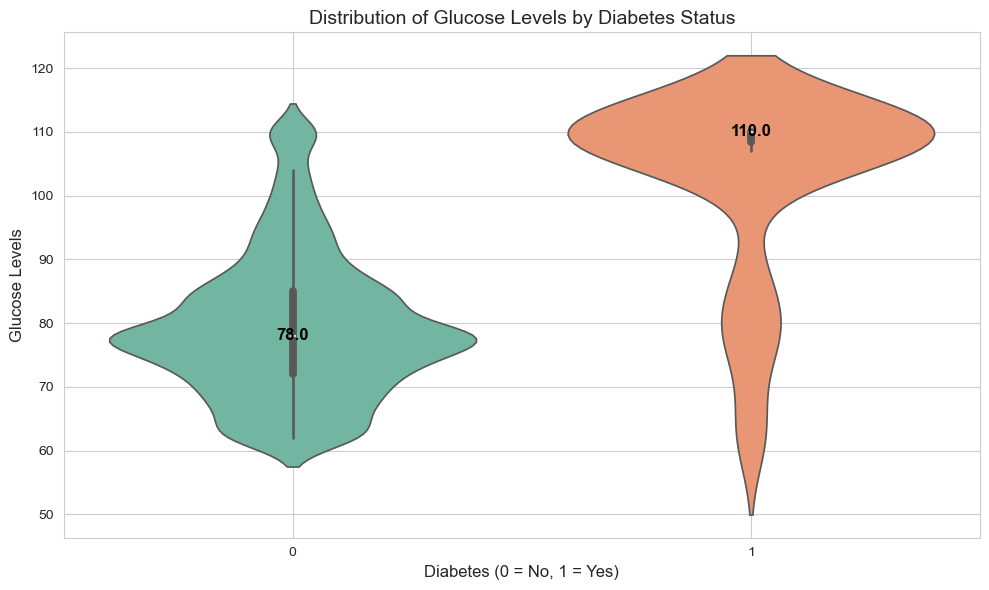

In [118]:
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='diabetes', y='glucose', data=df, palette='Set2')
medians = df.groupby('diabetes')['glucose'].median()
for i, median in enumerate(medians):
    ax.text(i, median, f'{median:.1f}', ha='center', va='center', fontsize=12, color='black', weight='bold')
    
plt.title('Distribution of Glucose Levels by Diabetes Status', fontsize=14)
plt.xlabel('Diabetes (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Glucose Levels', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


Elevated glucose levels are more prevalent and exhibit greater variability among diabetic patients compared to non-diabetic individuals. Diabetics have a broader range of glucose levels, often exceeding 95, with a median glucose level of 110. In contrast, non-diabetics generally have lower and less variable glucose levels, with a median of 78

##### Systolic Blood Pressure and Hypertension

/var/folders/ft/2bl2stsj05b84gz2r09gn9h40000gn/T/ipykernel_5682/2878985499.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='prevalentHyp', y='sysBP', data=df, palette='Set2')


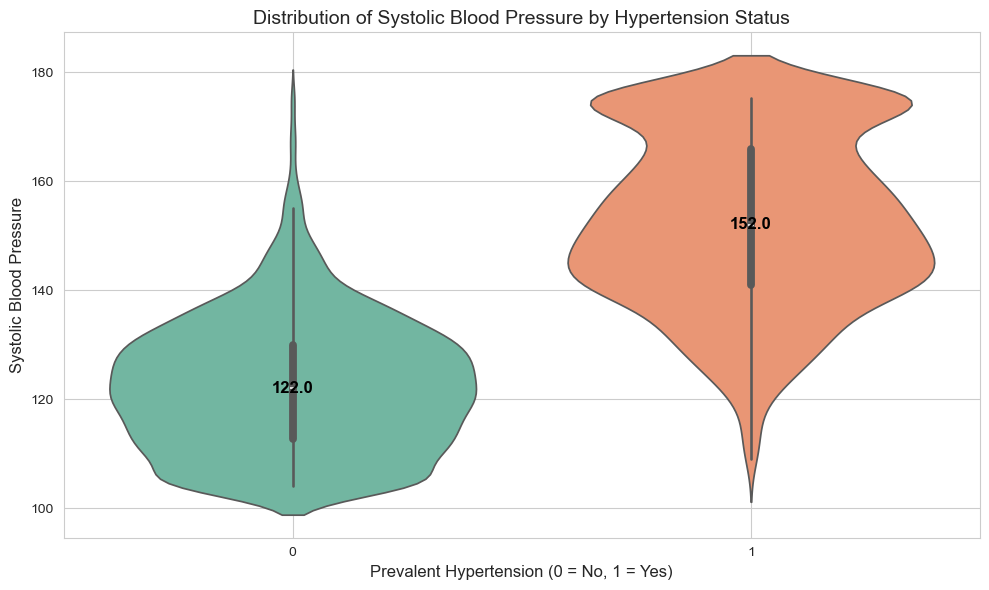

In [119]:
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='prevalentHyp', y='sysBP', data=df, palette='Set2')

medians = df.groupby('prevalentHyp')['sysBP'].median()

for i, median in enumerate(medians):
    ax.text(i, median, f'{median:.1f}', ha='center', va='center', fontsize=12, color='black', weight='bold')

plt.title('Distribution of Systolic Blood Pressure by Hypertension Status', fontsize=14)
plt.xlabel('Prevalent Hypertension (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Systolic Blood Pressure', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Individuals with hypertension exhibit significantly higher systolic blood pressure compared to those without hypertension. The median systolic blood pressure for individuals with hypertension is 152 mmHg, whereas for those without hypertension, it is 122 mmHg.

#### Diastolic Blood Pressure and Medication

/var/folders/ft/2bl2stsj05b84gz2r09gn9h40000gn/T/ipykernel_5682/3237189817.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='BPMeds', y='diaBP', data=df, palette='Set2')


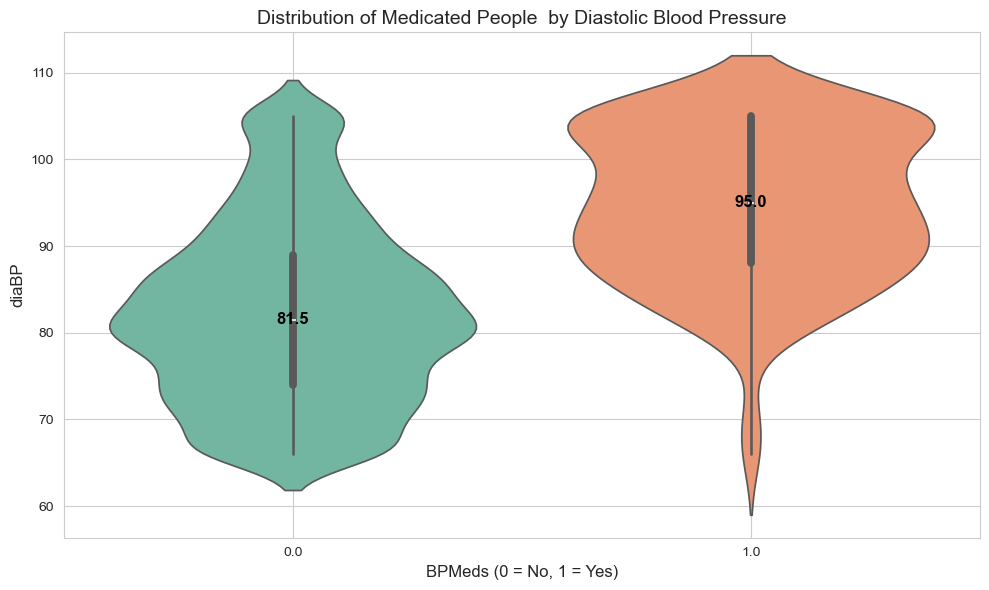

In [120]:
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='BPMeds', y='diaBP', data=df, palette='Set2')
medians = df.groupby('BPMeds')['diaBP'].median()

for i, median in enumerate(medians):
    ax.text(i, median, f'{median:.1f}', ha='center', va='center', fontsize=12, color='black', weight='bold')
    
plt.title('Distribution of Medicated People  by Diastolic Blood Pressure', fontsize=14)
plt.xlabel('BPMeds (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('diaBP', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Individuals on blood pressure medication tend to have a higher median diastolic blood pressure compared to those not on medication. Additionally, the majority of medicated individuals have diastolic pressure levels above 81.5 mmHg.

##### Distribution of Age by Stroke Status

/var/folders/ft/2bl2stsj05b84gz2r09gn9h40000gn/T/ipykernel_5682/475867783.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(x='prevalentStroke', y='age', data=df, palette='Set2')


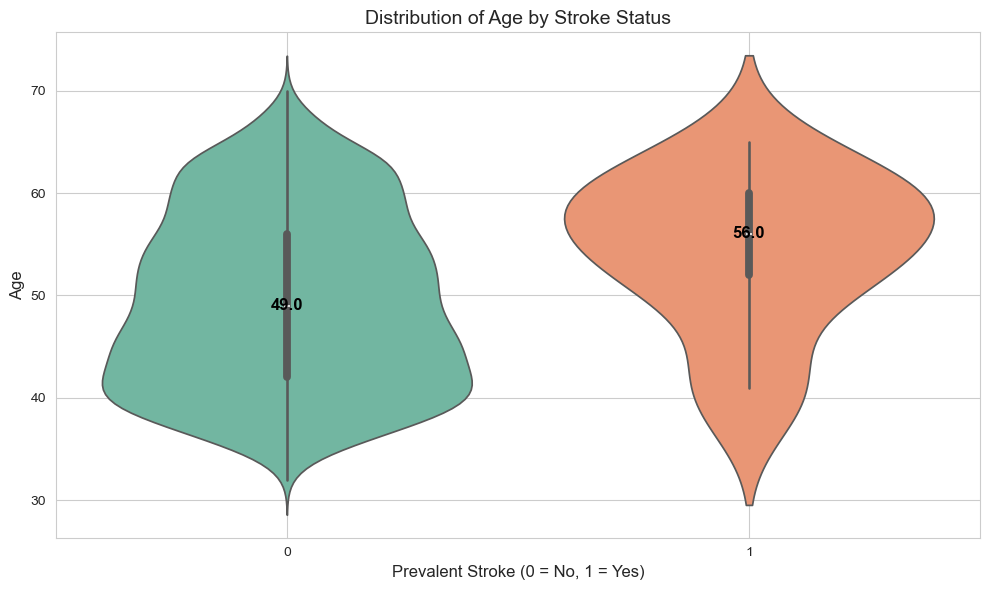

In [121]:
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='prevalentStroke', y='age', data=df, palette='Set2')

medians = df.groupby('prevalentStroke')['age'].median()
for i, median in enumerate(medians):
    ax.text(i, median, f'{median:.1f}', ha='center', va='center', fontsize=12, color='black', weight='bold')

plt.title('Distribution of Age by Stroke Status', fontsize=14)
plt.xlabel('Prevalent Stroke (0 = No, 1 = Yes)', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

Individuals with heart disease and a history of stroke tend to be older compared to their healthy counterparts. The median age for diseased individuals with a stroke is 56 years, while for healthy individuals without a stroke, it is 49 years.

#### Correlation heatmap

<Axes: >

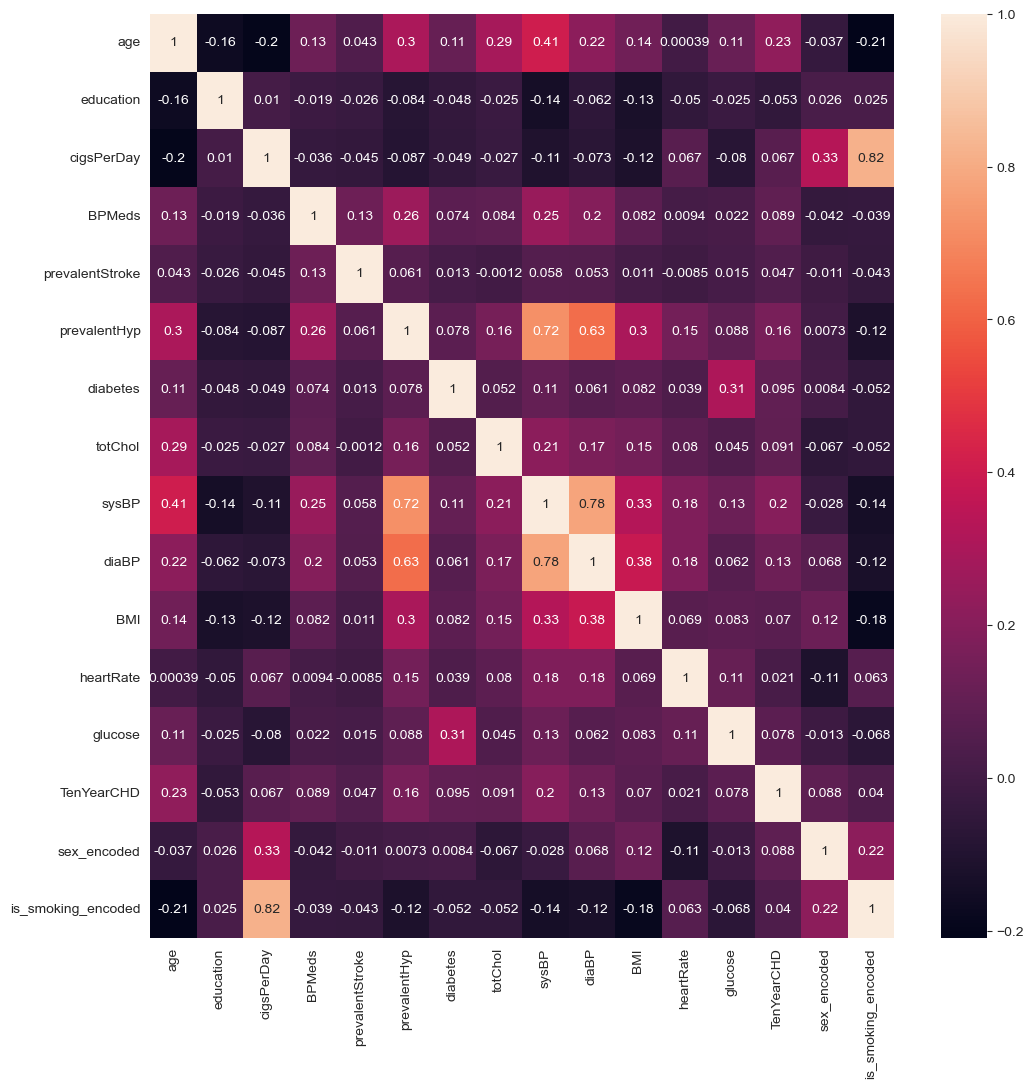

In [122]:
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(numeric_only=True), annot=True)

Independent variables 'diaBP' and 'sysBP' are highly correlated 0.78. Moreover, 'prevalentHyp' correlated with 'sysBP' and 'diaBP' (0.72 and 0.63).  Similiarly 'cigsPerDay' and 'is_smoking_encoded' has also quite high correlation of 0.82. In this case there is some multicollinearity problem. This must be taken into account during the regression modeling.

Target variable has quite low correlation with independent variables (below 0.23). 'Age' and 'sysBP' are  the most correlated variables to 'TenYearChD'. Education is the only variable that negatively correlated to Y.  
'is_smoking_encoded', 'education', 'prevalentStroke', and 'heartRate' has their R-coefficients are less or equal than 0.05, indicating minimal or negligible impact on the dependent variable.

##### Scaling continious variables

To enhance the performance of the logistic regression model, continuous variables are scaled using a logarithmic transformation. This transformation helps normalize the distribution of these variables, making them more suitable for the model's assumptions and improving overall predictive accuracy.


In [123]:
def apply_log1p(df, columns):
    for col in columns:
        df[col] = np.log1p(df[col])
    return df

columns_to_transform = ['age', 'cigsPerDay', 'totChol', 'sysBP', 
                        'diaBP', 'BMI', 'heartRate', 'glucose']

df = apply_log1p(df, columns_to_transform)

df.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,...,heartRate,glucose,TenYearCHD,sex_encoded,is_smoking_encoded,age_group,cigsPerDay_group,totChol_group,BMI_group,heartRate_group
1,3.610918,4.0,M,NO,0.000000,0.0,0,1,0,5.361292,...,4.290459,4.330733,0,1,0,"(31.962, 41.5]",0-5,"(205.112, 241.225]","(29.654, 32.853]","(69.5, 79.0]"
2,3.850148,1.0,F,YES,2.397895,0.0,0,0,0,5.525453,...,4.488636,4.553877,0,0,1,"(41.5, 51.0]",11-20,"(241.225, 277.337]","(20.047, 23.258]","(79.0, 88.5]"
3,3.931826,1.0,M,YES,3.044522,0.0,0,1,0,5.455321,...,4.234107,4.553877,1,1,1,"(41.5, 51.0]",21+,"(205.112, 241.225]","(26.456, 29.654]","(59.962, 69.5]"
4,4.174387,1.0,F,YES,3.433987,0.0,0,0,0,5.488938,...,4.262680,4.356709,0,0,1,"(60.5, 70.0]",NaN,"(205.112, 241.225]","(23.258, 26.456]","(69.5, 79.0]"
5,4.127134,3.0,F,NO,0.000000,0.0,0,1,0,5.609472,...,4.454347,4.189655,1,0,0,"(60.5, 70.0]",0-5,"(241.225, 277.337]","(29.654, 32.853]","(79.0, 88.5]"


## Model training

#### Logistic regression model

In [124]:
features = ['age', 'sex_encoded', 'cigsPerDay', 'BPMeds', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP', 'diaBP', 'BMI', 'glucose', 'is_smoking_encoded', 'education', 'prevalentStroke', 'heartRate']
target = 'TenYearCHD'
X = df[features]
y = df[target]
X_with_const = sm.add_constant(X)
model = sm.Logit(y, X_with_const)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.374988
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 3272
Model:                          Logit   Df Residuals:                     3256
Method:                           MLE   Df Model:                           15
Date:                Tue, 17 Sep 2024   Pseudo R-squ.:                  0.1098
Time:                        16:03:29   Log-Likelihood:                -1227.0
converged:                       True   LL-Null:                       -1378.2
Covariance Type:            nonrobust   LLR p-value:                 1.649e-55
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -30.7330      3.893     -7.895      0.000     -38.362     -23.104
age  

'BPMeds', 'prevalentHyp', 'totChol', 'diaBP', 'BMI', 'glucose', 'heartRate', 'education', 'is_smoking_encoded', and 'prevalentStroke' will be excluded from the logistic regression model due to their statistical significance levels being above the conventional threshold (e.g., p > 0.05). This suggests that these variables do not have a substantial effect on the outcome variable.

##### Adjusting the features

In [125]:
features = ['age', 'sex_encoded', 'cigsPerDay',   'diabetes',  'sysBP']
target = 'TenYearCHD'
X = df[features]
y = df[target]
X_with_const = sm.add_constant(X)
model = sm.Logit(y, X_with_const)
result = model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.377238
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:             TenYearCHD   No. Observations:                 3272
Model:                          Logit   Df Residuals:                     3266
Method:                           MLE   Df Model:                            5
Date:                Tue, 17 Sep 2024   Pseudo R-squ.:                  0.1044
Time:                        16:03:29   Log-Likelihood:                -1234.3
converged:                       True   LL-Null:                       -1378.2
Covariance Type:            nonrobust   LLR p-value:                 4.132e-60
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -29.5808      2.032    -14.561      0.000     -33.563     -25.599
age             3.6287    

This model can be used for further analysis, predictions, and refinement as needed. Independent variables such as age, sex(males), number of cigarettes per day, diabetes and systolic blood pressure are predictors and positively impact the disease(TenYearCHD).

##### Training a model

In the code below, a logistic regression model is trained using selected features and the target variable `TenYearCHD`.  
The dataset is split into training and testing sets with a 70-30 split, and the model is evaluated on the test set.   
The performance metrics include accuracy, confusion matrix, classification report, and ROC-AUC score to assess the model's effectiveness in predicting heart disease.

In [126]:
features = ['age', 'sex_encoded', 'cigsPerDay', 'diabetes',  'sysBP']
target = 'TenYearCHD'
X = df[features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)
print(f'ROC-AUC Score: {roc_auc}')

Accuracy: 0.6659877800407332
Confusion Matrix:
[[560 276]
 [ 52  94]]
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.67      0.77       836
           1       0.25      0.64      0.36       146

    accuracy                           0.67       982
   macro avg       0.58      0.66      0.57       982
weighted avg       0.82      0.67      0.71       982

ROC-AUC Score: 0.7108581306941075


The model correctly classified 66.6% of the instances in the test set.  
The confusion matrix shows that the model has a relatively high number of false positives (276), which indicates it incorrectly predicts some non-diseased individuals as diseased. The model performs better at identifying non-diseased individuals than diseased ones.  
Low precision of 0.25 indicates that only 25% of the predicted diseased cases are true positives(94).  
However, Precision for Class 0 (No Disease) is 0.92 and  it means that when the model predicts no disease, it is correct 91% of the time.

#### Threshold tuning (adjusting threshold)

In the analysis, the focus is on ensuring that as many diseased cases as possible are detected. By selecting a threshold of 0.3, we trade off some specificity to gain higher sensitivity. This decision aligns with the goal of minimizing false negatives and ensuring that individuals at risk are not overlooked.


--- Results with Adjusted Threshold (0.3) ---
Adjusted Accuracy: 0.3879837067209776
Adjusted Confusion Matrix:
[[248 588]
 [ 13 133]]
Adjusted Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.30      0.45       836
           1       0.18      0.91      0.31       146

    accuracy                           0.39       982
   macro avg       0.57      0.60      0.38       982
weighted avg       0.84      0.39      0.43       982

Adjusted ROC-AUC Score: 0.7108581306941075


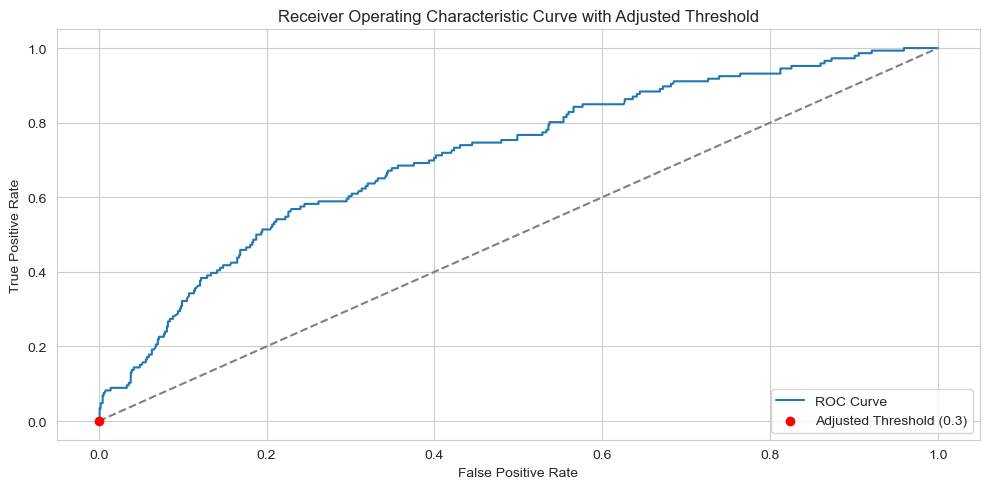

In [127]:
threshold = 0.3

y_prob = model.predict_proba(X_test)[:, 1]  

y_pred_adjusted = (y_prob >= threshold).astype(int)

accuracy_adjusted = accuracy_score(y_test, y_pred_adjusted)
conf_matrix_adjusted = confusion_matrix(y_test, y_pred_adjusted)
class_report_adjusted = classification_report(y_test, y_pred_adjusted)
roc_auc_adjusted = roc_auc_score(y_test, y_prob)

print(f'\n--- Results with Adjusted Threshold ({threshold}) ---')
print(f'Adjusted Accuracy: {accuracy_adjusted}')
print('Adjusted Confusion Matrix:')
print(conf_matrix_adjusted)
print('Adjusted Classification Report:')
print(class_report_adjusted)
print(f'Adjusted ROC-AUC Score: {roc_auc_adjusted}')

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_prob)

sns.set_style('whitegrid')
plt.figure(figsize=(10, 5))
plt.plot(false_positive_rate, true_positive_rate, label='ROC Curve')
plt.plot([0, 1], [0, 1], ls='--', color='grey')

threshold_index = (thresholds >= threshold).argmax()
plt.scatter(
    false_positive_rate[threshold_index], 
    true_positive_rate[threshold_index], 
    color='red', 
    label=f'Adjusted Threshold ({threshold})', 
    zorder=5
)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve with Adjusted Threshold')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


Confusion Matrix:  
- True Negatives (TN): The model correctly predicted 248 non-diseased cases.  
- False Positives (FP): The model incorrectly classified 588 non-diseased cases as diseased. This high number indicates that the lower threshold significantly increased false positives.  
- False Negatives (FN): The model missed 13 diseased cases, which is relatively low.  
- True Positives (TP): The model correctly identified 133 diseased cases.

Classification Report:  
- For Class 0 (Non-Diseased):  
Precision: **0.95** - When the model predicts a case as non-diseased, it is correct 95% of the time.  
Recall: 0.30 - The model only identifies 30% of the actual non-diseased cases correctly.  
- For Class 1 (Diseased):  
Precision: 0.18 - When the model predicts a case as diseased, it is correct only 18% of the time.  
Recall: **0.91** - The model identifies 91% of the actual diseased cases, which indicates high sensitivity.


With an ROC-AUC score  of 0.71, the model is reasonably good at distinguishing between the two classes (positive and negative). However, there is still area for improvement in terms of its overall predictive ability.

## Conclusion

The dataset underwent rigorous preprocessing to ensure the quality and reliability of the analysis. Missing values were handled appropriately, and categorical variables like gender and smoking status were encoded. Outliers, particularly in variables such as glucose and systolic blood pressure, were carefully examined and addressed. A logarithmic transformation was applied to normalize the skewed distributions of certain variables, thereby enhancing the performance of the logistic regression model. This step was crucial for improving the predictive accuracy of the model, particularly for variables that exhibited significant skewness.

The logistic regression model identified key predictors of heart disease, including age, systolic blood pressure (sysBP), smoking (cigsPerDay), sex, and diabetes. These factors were found to have the most significant impact on predicting coronary heart disease, as evidenced by their statistical significance and coefficients in the model. Specifically:
- **Systolic blood pressure (sysBP):** Higher systolic blood pressure was strongly associated with an increased risk of CHD.
- **Age:** Older individuals were at a significantly higher risk of developing heart disease.
- **Smoking:** There was a clear correlation between smoking habits and CHD risk, underscoring its role as a major cardiovascular risk factor.
- **Diabetes:** Diabetic individuals had a notably higher likelihood of developing heart disease.
- **Gender:** Males were generally at a higher risk of CHD compared to females, which is consistent with existing medical literature on sex-related differences in heart disease prevalence.

The logistic regression model demonstrated moderate accuracy (66%) and an ROC-AUC score of 0.71, indicating a reasonable level of discriminatory power. However, the model's precision for identifying heart disease (positive class) was relatively low, signaling the need for further optimization. 

In the analysis, there was a deliberate focus on detecting as many diseased cases as possible, leading to the selection of a threshold of 0.3 instead of the conventional 0.5. This adjustment improved the model's **sensitivity** (recall), ensuring more heart disease cases were identified (91% recall for diseased individuals). However, this improvement in recall came at the expense of **specificity**, as more non-diseased individuals were misclassified as diseased, leading to an increased number of false positives.


### Areas of improvement

- Increased sample size can lead to better training and validation, potentially enhancing the model's ability to detect patterns associated with heart disease.  
- Incorporating new features or deriving additional variables could be relevant to improvement of heart disease prediction.    
- Apply other classification algorithms (f.e. random forest).  
- Optimization of ROC curve performance.